In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import pandas as pd
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import exposure
import cv2

import re
import time
import pydicom as dicom

In [9]:
every_slice_info=pd.read_csv('every_slice_info.csv')
every_seg_slice_instance_df=pd.read_csv('every_seg_slice_instance_df.csv')
every_slice_sop_instance_df=pd.read_csv('every_slice_sop_instance_df.csv')
certain_slices_have_seg_df=pd.read_csv('certain_slices_have_seg_df_2.csv')

In [10]:
certain_slices_have_seg_df

,Unnamed: 0,Unnamed: 0.1,slice_path,slice_sop_instance_uid
0,0,46,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.110383487652...
1,1,45,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.499837844441...
2,2,44,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.299410838455...
3,3,43,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.824843590991...
4,4,42,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.297813206491...
...,...,...,...,...
39776,39776,242821,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.108262053466...
39777,39777,242820,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.260274030734...
39778,39778,242823,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.165495951444...
39779,39779,242822,D:\LIDC\manifest-1600709154662\LIDC-IDRI\LIDC-...,1.3.6.1.4.1.14519.5.2.1.6279.6001.172698955704...


In [11]:
certain_slices_have_seg_df['slice_path'][0]

'D:\\LIDC\\manifest-1600709154662\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-NA-NA-30178\\3000566.000000-NA-03192\\1-047.dcm'

In [12]:
certain_slices_have_seg_df.shape

(39781, 4)

# Test data

In [104]:
patient_path_test='D:\RIDER\original\manifest-1581629373965\RIDER Lung CT'

patient_test=os.listdir(patient_path_test)

every_test_slice_path=[]
for i in range(len(patient_test)):
    patient_test_i=os.path.join(patient_path_test,patient_test[i])
    sub_folder_1=os.listdir(patient_test_i)[0]
    sub_folder_2=os.listdir(os.path.join(patient_test_i,sub_folder_1))[0]
    path=os.path.join(patient_test_i,sub_folder_1,sub_folder_2)
    for file in os.listdir(path):
        if file.endswith('.dcm'):
            full_path=os.path.join(path,file)
            every_test_slice_path.append(full_path) 

In [105]:
every_test_slice_path

['D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\RIDER-1129164940\\09-20-2006-1-NA-96508\\4.000000-NA-24533\\1-001.dcm',
 'D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\RIDER-1129164940\\09-20-2006-1-NA-96508\\4.000000-NA-24533\\1-002.dcm',
 'D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\RIDER-1129164940\\09-20-2006-1-NA-96508\\4.000000-NA-24533\\1-003.dcm',
 'D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\RIDER-1129164940\\09-20-2006-1-NA-96508\\4.000000-NA-24533\\1-004.dcm',
 'D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\RIDER-1129164940\\09-20-2006-1-NA-96508\\4.000000-NA-24533\\1-005.dcm',
 'D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\RIDER-1129164940\\09-20-2006-1-NA-96508\\4.000000-NA-24533\\1-006.dcm',
 'D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\RIDER-1129164940\\09-20-2006-1-NA-96508\\4.000000-NA-24533\\1-007.dcm',
 'D:\\RIDER\\original\\manifest-1581629373965\\RIDER Lung CT\\

# Resizing training images and masks

In [42]:
IMG_CHANNELS=1
IMG_PX_SIZE=256
IMG_HEIGHT=256
IMG_WIDTH=256

In [43]:
train_ids = len(certain_slices_have_seg_df)
test_ids = len(every_test_slice_path)

In [44]:
train_ids

39781

In [45]:
X_train = np.zeros((train_ids, IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)  #np.uint8
Y_train = np.zeros((train_ids, IMG_HEIGHT, IMG_WIDTH,1), dtype=np.uint8)

In [46]:
X_train.shape 

(39781, 256, 256, 1)

In [47]:
Y_train.shape

(39781, 256, 256, 1)

In [48]:
train_ids

39781

In [49]:
test_ids

7666

In [50]:
image_windowing=np.zeros((len(certain_slices_have_seg_df),512,512), dtype=np.uint8)
start_time=time.time()
for i in range(len(certain_slices_have_seg_df)):
    filename=certain_slices_have_seg_df['slice_path'][i]
    ds=dicom.dcmread(filename) 
    p_lo, p_hi = np.percentile(ds.pixel_array, (22, 99.5))
    img_rescale = exposure.rescale_intensity(ds.pixel_array, in_range=(p_lo, p_hi))
    outputImg8U = cv2.convertScaleAbs(img_rescale, alpha=(255.0/32767))
    image_windowing[i]=outputImg8U
print("--- %s seconds ---"%(time.time()-start_time))    

--- 211.29927110671997 seconds ---


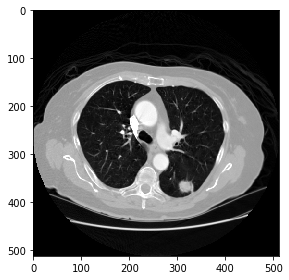

In [51]:
imshow(image_windowing[6])

In [52]:
image_windowing.shape

(39781, 512, 512)

In [53]:
ds=image_windowing[6]
ds.shape

(512, 512)

In [54]:
np.amax(ds)

255

In [55]:
ds.dtype

dtype('uint8')

In [57]:
image_thresholding=np.zeros((len(certain_slices_have_seg_df),512,512), dtype=np.uint8)
start_time=time.time()
for i in range(len(certain_slices_have_seg_df)):
    ds=image_windowing[i]
    ret,image_thresholding[i]=cv2.threshold(ds,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print("--- %s seconds ---"%(time.time()-start_time))    

--- 6.970292329788208 seconds ---


In [58]:
start_time=time.time()
for i in range(len(certain_slices_have_seg_df)):
        img=resize(image_thresholding[i],(IMG_PX_SIZE,IMG_PX_SIZE,IMG_CHANNELS),mode='constant', preserve_range=True)
        X_train[i] = img

print("--- %s seconds ---"%(time.time()-start_time))

--- 182.20060324668884 seconds ---


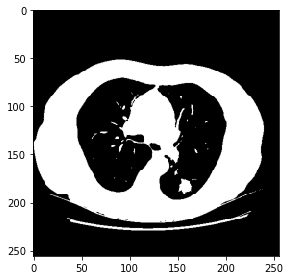

In [59]:
imshow(X_train[1])

In [60]:
Y_train.shape

(39781, 256, 256, 1)

In [61]:
start_time=time.time()
mask = np.zeros((IMG_PX_SIZE, IMG_PX_SIZE,1), dtype=bool)
b=0
for n in range(len(every_seg_path)):
    filename=every_seg_path[n]
    ds=dicom.dcmread(filename) 
    data=ds.pixel_array
    len_data=len(data)
    if len_data==512:
        data_downsampling = data[::4, ::4]
        img=resize(data,(IMG_PX_SIZE,IMG_PX_SIZE,1),mode='constant',preserve_range=True,anti_aliasing=False)
        Y_train[b] = img
        b=b+1
    if len_data<512:
        for j in range(len_data):
            data_downsampling = data[j][::4, ::4]
            img=resize(data_downsampling,(IMG_PX_SIZE,IMG_PX_SIZE,1),mode='constant',preserve_range=True,anti_aliasing=False)
            Y_train[b] = img
            b=b+1

print("--- %s seconds ---"%(time.time()-start_time))

--- 215.56399130821228 seconds ---


In [62]:
Y_train[20].shape

(256, 256, 1)

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


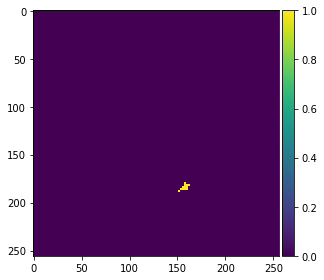

In [63]:
imshow(Y_train[0])

In [64]:
X_test = np.zeros((test_ids, IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

In [65]:
image_windowing_X_test=np.zeros((len(certain_slices_have_seg_df),512,512), dtype=np.uint8)
start_time=time.time()
for i in range(len(every_test_slice_path)):
    filename=every_test_slice_path[i]
    ds=dicom.dcmread(filename) 
    p_lo, p_hi = np.percentile(ds.pixel_array, (22, 99.5))
    img_rescale = exposure.rescale_intensity(ds.pixel_array, in_range=(p_lo, p_hi))
    outputImg8U = cv2.convertScaleAbs(img_rescale, alpha=(255.0/32767))
    image_windowing_X_test[i]=outputImg8U
print("--- %s seconds ---"%(time.time()-start_time))    

--- 114.86448264122009 seconds ---


In [66]:
image_thresholding_X_test=np.zeros((len(certain_slices_have_seg_df),512,512), dtype=np.uint8)
start_time=time.time()
for i in range(len(every_test_slice_path)):
    ds=image_windowing_X_test[i]
    ret,image_thresholding_X_test[i]=cv2.threshold(ds,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print("--- %s seconds ---"%(time.time()-start_time))    

--- 1.242084264755249 seconds ---


In [67]:
start_time=time.time()
for i in range(len(every_test_slice_path)):
    img=resize(image_thresholding_X_test[i],(IMG_PX_SIZE,IMG_PX_SIZE,IMG_CHANNELS), mode='constant', preserve_range=True)
    X_test[i] = img
print("--- %s seconds ---"%(time.time()-start_time))

--- 34.59887909889221 seconds ---


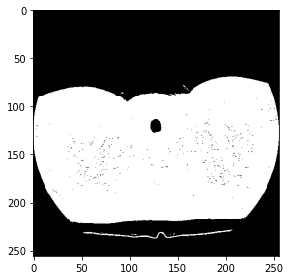

In [68]:
imshow(X_test[0])

In [69]:
X_test.shape

(7666, 256, 256, 1)

In [70]:
X_train.shape

(39781, 256, 256, 1)

In [71]:
Y_train.shape

(39781, 256, 256, 1)

4185


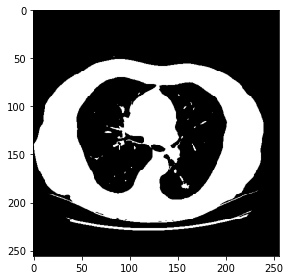

In [72]:
image_x = random.randint(0, train_ids)
print(image_x)
imshow(X_train[0])
plt.show()

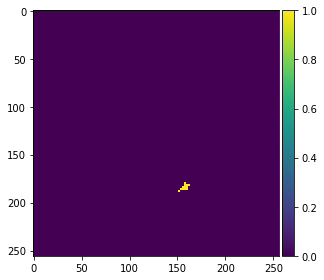

In [73]:
imshow(np.squeeze(Y_train[0]))
plt.show()

In [74]:
inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)


#L1
c00=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
p1=tf.keras.layers.MaxPooling2D((2,2))(c00)

c10=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)

u1=tf.keras.layers.Conv2DTranspose(16,(3,3),strides=(2,2),padding='same')(c10)
u1=tf.keras.layers.concatenate([u1,c00])
c01=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)

#L2
p2=tf.keras.layers.MaxPooling2D((2,2))(c10)
c20=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)

u2=tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same')(c20)
u2=tf.keras.layers.concatenate([u2,c10])
c11=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)

u3=tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(c11)
u3=tf.keras.layers.concatenate([u3,c01])
u3=tf.keras.layers.concatenate([u3,c00])
c02=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)

#L3
p3=tf.keras.layers.MaxPooling2D((2,2))(c20)
c30=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)

u4=tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same')(c30)
u4=tf.keras.layers.concatenate([u4,c20])
c21=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)


u5=tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same')(c21)
u5=tf.keras.layers.concatenate([u5,c11])
u5=tf.keras.layers.concatenate([u5,c10])
c12=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u5)


u6=tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(c12)
u6=tf.keras.layers.concatenate([u6,c02])
u6=tf.keras.layers.concatenate([u6,c00])
c03=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)

#L4
p4=tf.keras.layers.MaxPooling2D((2,2))(c30)
c40=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)

u7=tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding='same')(c40)
u7=tf.keras.layers.concatenate([u7,c30])
c31=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)

u8=tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same')(c31)
u8=tf.keras.layers.concatenate([u8,c21])
u8=tf.keras.layers.concatenate([u8,c20])
c22=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)

u9=tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same')(c22)
u9=tf.keras.layers.concatenate([u9,c12])
u9=tf.keras.layers.concatenate([u9,c10])
c13=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)

u10=tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(c13)
u10=tf.keras.layers.concatenate([u10,c03])
u10=tf.keras.layers.concatenate([u10,c00])
c04=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u10)

outputs=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c04)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [116]:
inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)

#Contraction path
c1=tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

c2=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3,),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
c3=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
c4=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

c6=tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p5)
c6=tf.keras.layers.Dropout(0.3)(c6)
c6=tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
c6=tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
p6=tf.keras.layers.MaxPooling2D((2,2))(c6)

c7=tf.keras.layers.Conv2D(2048,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p6)
c7=tf.keras.layers.Dropout(0.3)(c7)
c7=tf.keras.layers.Conv2D(2048,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
c7=tf.keras.layers.Conv2D(20,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

#Expansive path 
u8=tf.keras.layers.Conv2DTranspose(1024,(2,2),strides=(2,2),padding='same')(c7)
u8=tf.keras.layers.concatenate([u8,c6])
c8=tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8=tf.keras.layers.Dropout(0.2)(c8)
c8=tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9=tf.keras.layers.Conv2DTranspose(512,(2,2),strides=(2,2),padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c5])
c9=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9=tf.keras.layers.Dropout(0.2)(c9)
c9=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

u10=tf.keras.layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(u9)
u10=tf.keras.layers.concatenate([u10,c4])
c10=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u10)
c10=tf.keras.layers.Dropout(0.1)(c10)
c10=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c10)
u11=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(u10)
u11=tf.keras.layers.concatenate([u11,c3])
c11=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u11)
c11=tf.keras.layers.Dropout(0.1)(c11)
c11=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c11)
u12=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(u11)
u12=tf.keras.layers.concatenate([u12,c2])
c12=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u12)
c12=tf.keras.layers.Dropout(0.1)(c12)
c12=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c12)
u13=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(u12)
u13=tf.keras.layers.concatenate([u13,c1])
c13=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u13)
c13=tf.keras.layers.Dropout(0.1)(c13)
c13=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c13)

outputs=tf.keras.layers.Conv2D(1,(1,1),activation='relu')(c13)
model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 32  320         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [75]:
start_time=time.time()
#Modelcheckpoint
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_for_lung_nodule_detection.h5',verbose=1,save_best_only=True)

callbacks=[\
          tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
          tf.keras.callbacks.TensorBoard(log_dir='logs')]

results=model.fit(X_train,Y_train,validation_split=0.2,batch_size=16,epochs=25,callbacks=callbacks)
print("--- %s seconds ---"%(time.time()-start_time))

Epoch 1/25
1989/1989 [==============================] - 14511s 7s/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 2/25
1989/1989 [==============================] - 14332s 7s/step - loss: 4.6766e-04 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 3/25
1989/1989 [==============================] - 14432s 7s/step - loss: 3.6487e-04 - accuracy: 0.9999 - val_loss: 0.0013 - val_accuracy: 0.9998
--- 43275.5463476181 seconds ---


In [76]:
model.save('D:\Code\model_for_lung_nodule_detection_unetplus256.h5')

In [77]:
idx = random.randint(0, len(X_train))

In [78]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val=model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
preds_test=model.predict(X_test,verbose=1)

240/240 [==============================] - 622s 3s/step


In [79]:
preds_train_t=(preds_train>0.5).astype(np.uint8)
preds_val_t=(preds_val>0.5).astype(np.uint8)
preds_test_t=(preds_test>0.5).astype(np.uint8)

21107


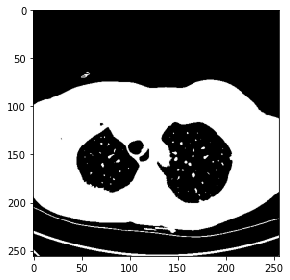

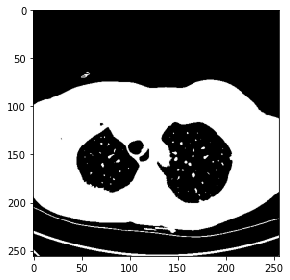

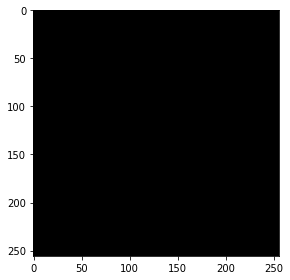

In [80]:
ix=random.randint(0, len(preds_train_t))
print(ix)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(X_train[ix]))
plt.show()

imshow(np.squeeze(preds_train_t[ix]), cmap='gray', vmin=0,vmax=1)
plt.show()

0


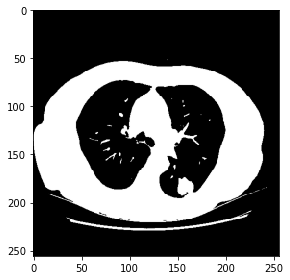

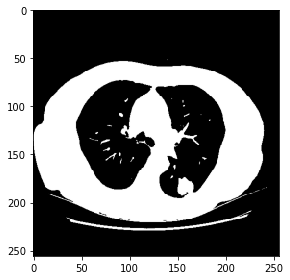

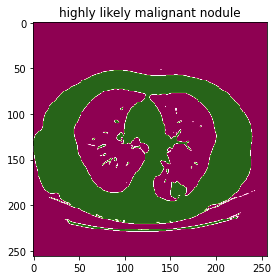

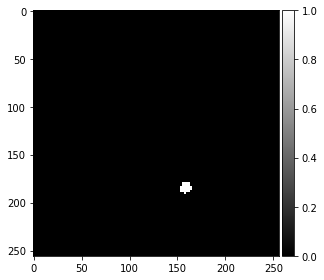

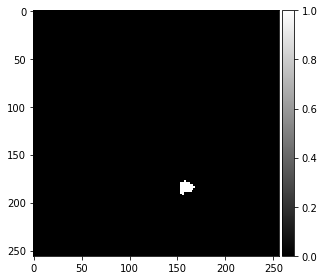

In [81]:
#ix=random.randint(0, len(preds_train_t))
print(0)
imshow(X_train[4])
plt.show()
imshow(np.squeeze(X_train[4]))
plt.show()
Msk_Img=np.squeeze(preds_train_t[4])
ret, thresh = cv2.threshold(Msk_Img, 127, 255, 0)
contours, hierarchy = cv2.findContours(Msk_Img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
area = cv2.contourArea(cnt)
Img=X_train[4]
if area>30.0: plt.title("highly likely malignant nodule")
    
if area<30.0: plt.title("likely benign nodule")
img_contour=cv2.drawContours(Img, contours, -1, (255, 255, 255),1)
imshow(img_contour, cmap ="PiYG")
plt.show()

imshow(np.squeeze(preds_train_t[1]), cmap='gray', vmin=0,vmax=1)
plt.show()

cnt = contours[0]
area = cv2.contourArea(cnt)

imshow(np.squeeze(Y_train[4]), cmap='gray', vmin=0,vmax=1)
plt.show()    

12663


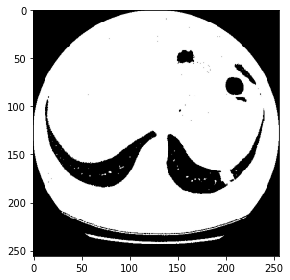

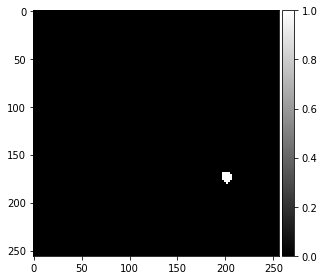

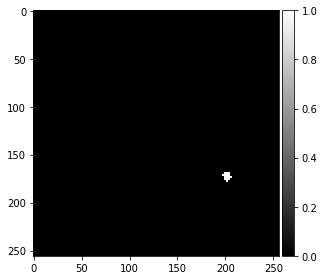

In [82]:
ix=random.randint(0, len(preds_train_t))
print(12663)
imshow(X_train[12663])
plt.show()

imshow(np.squeeze(preds_train_t[12663]), cmap='gray', vmin=0,vmax=1)
plt.show()
imshow(np.squeeze(Y_train[12663]), cmap='gray', vmin=0,vmax=1)
plt.show() 

91


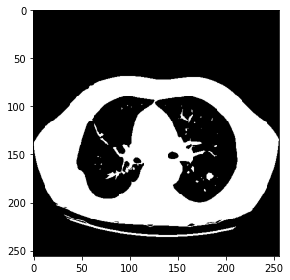

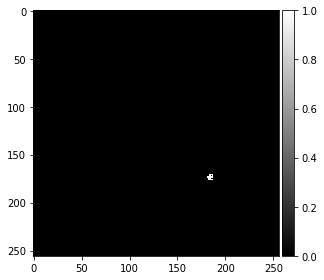

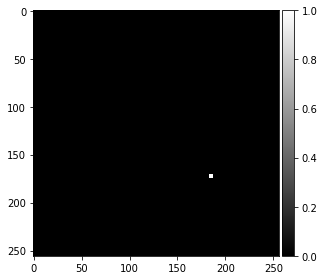

In [83]:
ix=random.randint(0, len(preds_train_t))
print(91)
imshow(X_train[91])
plt.show()

imshow(np.squeeze(preds_train_t[91]), cmap='gray', vmin=0,vmax=1)
plt.show()
imshow(np.squeeze(Y_train[91]), cmap='gray', vmin=0,vmax=1)
plt.show() 

123


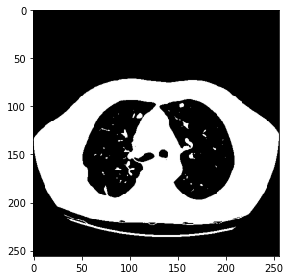

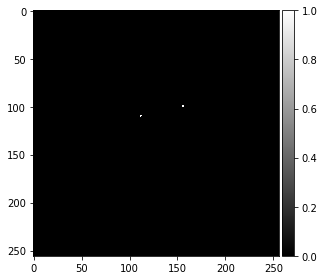

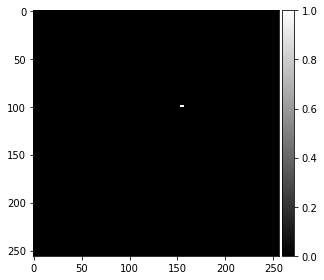

In [84]:
ix=random.randint(0, len(preds_train_t))
print(123)
imshow(X_train[123])
plt.show()

imshow(np.squeeze(preds_train_t[123]), cmap='gray', vmin=0,vmax=1)
plt.show()
imshow(np.squeeze(Y_train[123]), cmap='gray', vmin=0,vmax=1)
plt.show() 

12663


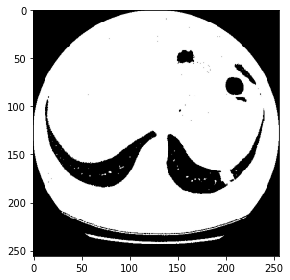

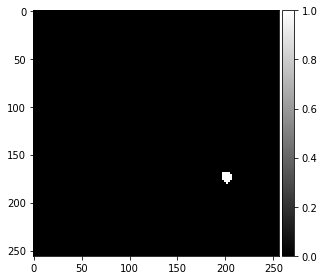

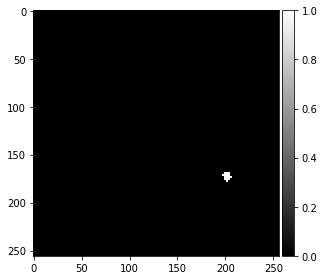

In [85]:
ix=random.randint(0, len(preds_train_t))
print(12663)
imshow(X_train[12663])
plt.show()

imshow(np.squeeze(preds_train_t[12663]), cmap='gray', vmin=0,vmax=1)
plt.show()
imshow(np.squeeze(Y_train[12663]), cmap='gray', vmin=0,vmax=1)
plt.show() 

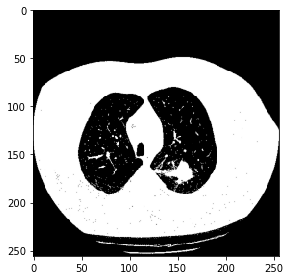

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


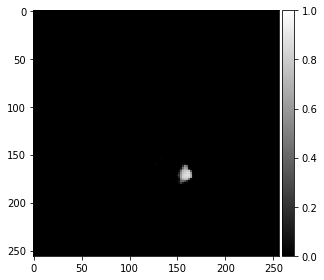

In [102]:
imshow(X_test[2541])
plt.show()

imshow(np.squeeze(preds_test[2541]), cmap='gray', vmin=0,vmax=1)
plt.show()